# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

import os
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import glob

from urbanmask.urban_areas import (
    Urban_vicinity,
)

from urbanmask.UHI_plot_functions import (
    compute_climatology,
    plot_climatology,
    compute_time_series,
    plot_time_series
)

from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
)

In [2]:
from lib.utils import latest_version, fix_360_longitudes
from lib.interpolater import Interpolator

## Input parameters

These parameters define the behavior of the notebook by selecting the `city`, `variable`, and other items, most of which are self-explanatory. _(Provide additional explanations here for any parameters that are not self-explanatory)._

In [3]:
# Parameters
city = 'Paris'
name = 'Paris'
lon_city = 2.35
lat_city = 48.85

model = 'CERRA'
variable= 't'

urban_th = 60
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 0
lon_lim = 1
lat_lim = 1

In [4]:
# Parameters
name = "Baghdad"
abbr_city = "Baghdad"
lon_city = 44.4
lat_city = 33.34
variable = "tasmin"
urban_th = 60
urban_sur_th = 10
orog_diff = 100
sftlf_th = 70
lon_lim = 1.5
lat_lim = 1.2
min_city_size = 0


Create a directory to save the results for this particular city and model

In [5]:
base_output_dir = 'results_CERRA'
output_dir = f"{base_output_dir}/{city}_{model}"
os.makedirs(output_dir, exist_ok = True)

Infer doman resolution in degrees and create filename

In [6]:
#domain_resolution = int(domain.split('-')[1])
base_filename = f'{city}-ECMWF-ERA5_r1i1p1f1_{model}'

## Define urban areas and vicinity

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [7]:
root = '/lustre/gmeteo/WORK/DATA/C3S-CDS/'

ds_orog = xr.open_dataset(f'{root}/CERRA/fx/orog_CERRA_fx.nc')
ds_sftlf = xr.open_dataset(f'{root}/CERRA/fx/lsm_CERRA_fx.nc')
ds_sftuf = xr.open_dataset(f'{root}/CERRA-Land/fx/CERRALand_tiles_fraction.nc')

In [8]:
# Process orography
ds_orog = ds_orog.isel(valid_time=0)
ds_orog = ds_orog.rename({'longitude': 'lon', 'latitude': 'lat'})

# Process land-sea mask, converting values for land percentage
ds_sftlf = ds_sftlf.isel(valid_time=0)
ds_sftlf['sftlf'] = ds_sftlf['lsm'] * 100
ds_sftlf = ds_sftlf.drop_vars('lsm').rename({'longitude': 'lon', 'latitude': 'lat'})

# Process land-sea mask, converting values for land percentage
ds_sftuf = ds_sftuf.isel(oneD=0)
ds_sftuf['sftuf'] = ds_sftuf['frac_urban'] * 100
#ds_sftuf = ds_sftuf.drop_vars('frac_urban').rename({'x': 'lon', 'y': 'lat'})
ds_sftuf = ds_sftuf.assign_coords({'lat': ds_orog['lat'], 'lon': ds_orog['lon']})

Add parameters to the function

In [9]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model)

### Load climate variable

Crop area around de city

In [10]:
root = "/lustre/gmeteo/WORK/DATA/C3S-CDS/C3S-CICA-Atlas/v2/"
domain= "CERRA"
name= "t_CERRA_mon_198501-202112_v02.nc"

In [11]:
root_nc = root + domain + '/' + name
var = name.split('_')[0]

ds_RCM = xr.open_dataset(root_nc, engine="netcdf4", 
                    chunks={"member": 1, "time": 120})


# Crop the area for the city using the domain resolution
# Define trimming limits
lat_min = lat_city - lat_lim
lat_max = lat_city + lat_lim
lon_min = lon_city - lon_lim
lon_max = lon_city + lon_lim

# Crop the dataset
ds_RCM = ds_RCM.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

/oceano/gmeteo/users/quintanay/mambaforge/lib/python3.10/site-packages/xarray/conventions.py:287: SerializationWarning: variable 't' has multiple fill values {1.0384594e+34, -1.7014118e+38} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/oceano/gmeteo/users/quintanay/mambaforge/lib/python3.10/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


### Interpolation of the static variable

In [12]:
# Interpolate data
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : ds_RCM.lat.values,
            'lons' : ds_RCM.lon.values,
            'var_name' : 'sftuf'
}

INTER = Interpolator(int_attr)
ds_sftuf = INTER(ds_sftuf)

int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : ds_RCM.lat.values,
            'lons' : ds_RCM.lon.values,
            'var_name' : 'orog'
}
INTER = Interpolator(int_attr)
ds_orog = INTER(ds_orog)

int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : ds_RCM.lat.values,
            'lons' : ds_RCM.lon.values,
            'var_name' : 'sftlf'
}
INTER = Interpolator(int_attr)
ds_sftlf = INTER(ds_sftlf)

/oceano/gmeteo/users/quintanay/mambaforge/lib/python3.10/site-packages/xesmf/smm.py:197: RuntimeWarning: invalid value encountered in cast
  outdata = outdata.astype(indata_dtype)


/oceano/gmeteo/users/quintanay/mambaforge/lib/python3.10/site-packages/xesmf/smm.py:197: RuntimeWarning: invalid value encountered in cast
  outdata = outdata.astype(indata_dtype)


/oceano/gmeteo/users/quintanay/mambaforge/lib/python3.10/site-packages/xesmf/smm.py:197: RuntimeWarning: invalid value encountered in cast
  outdata = outdata.astype(indata_dtype)


### Create urban_mask

Define masks using the parameters above

In [13]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [14]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

/lustre/gmeteo/WORK/quintanay/C3S-CICA-Atlas/urbanmask/urban_areas.py:459: RuntimeWarning: All-NaN axis encountered
  vmin = np.nanmin(ds_orog['orog']),
/lustre/gmeteo/WORK/quintanay/C3S-CICA-Atlas/urbanmask/urban_areas.py:460: RuntimeWarning: All-NaN axis encountered
  vmax = np.nanmax(ds_orog['orog'])
/lustre/gmeteo/WORK/quintanay/C3S-CICA-Atlas/urbanmask/urban_areas.py:474: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(abs(ds_sftuf["sftuf"].where(sftuf_mask == 1, np.nan).values))
/lustre/gmeteo/WORK/quintanay/C3S-CICA-Atlas/urbanmask/urban_areas.py:488: RuntimeWarning: All-NaN axis encountered
  vmin = np.nanmin(ds_orog['orog']),
/lustre/gmeteo/WORK/quintanay/C3S-CICA-Atlas/urbanmask/urban_areas.py:489: RuntimeWarning: All-NaN axis encountered
  vmax = np.nanmax(ds_orog['orog'])


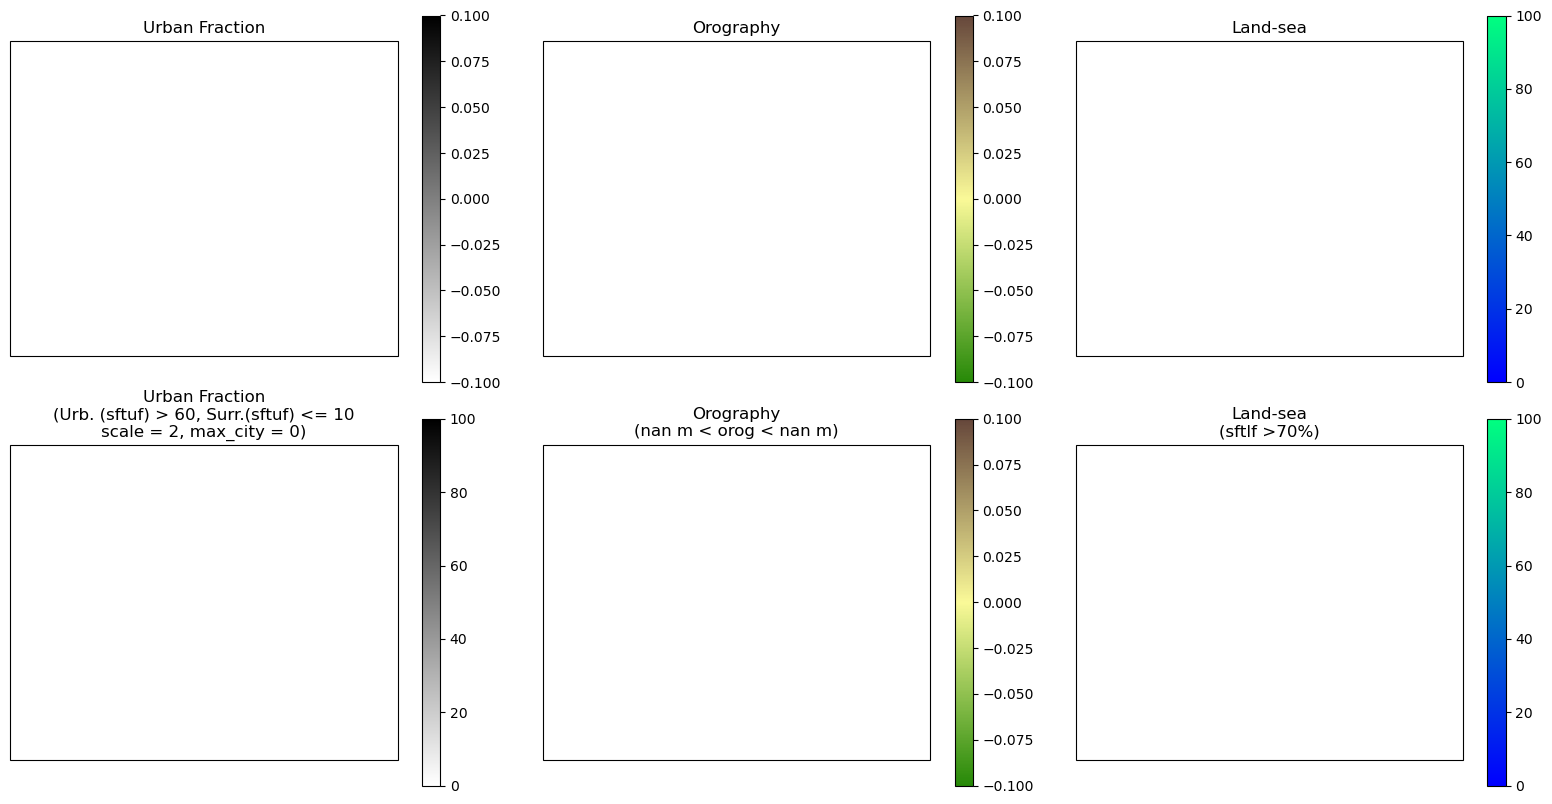

In [15]:
fig = URBAN.plot_static_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

Save these masks and urban fraction to NetCDF

In [16]:
urmask.to_netcdf(f"{output_dir}/urmask_{base_filename}_fx.nc")
ds_sftuf.rename_vars({'sftuf': 'sfturf'}).to_netcdf(f"{output_dir}/sfturf_{base_filename}_fx.nc")